### Install dependencies

In [17]:
%pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 7.3 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 23.9 MB/s  eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [280]:
import re
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

from collections import Counter

### Read data from CSV

In [251]:
DATA = 'data/menuitems.csv'
df = pd.read_csv(DATA)
print(df.describe())

       Restaurant Name     Original food Item
count             4524                   4524
unique             341                   4330
top        Happy Joe's  Chocolate Chip Cookie
freq                48                     11


In [252]:
# Datafram columns:
RESTAURANT = 'Restaurant Name'
ITEM = 'Original food Item'
EMBEDDING = 'Embedding'
CLUSTER = 'Cluster'

### Data cleaning

Very basic, remove non-alphabetic characters and measure like fl oz and inch

In [253]:
def clean_item(item):
    # Remove these measures as they are creating spurious clusters
    rem = ['oz', 'fl', 'inch']
    for r in rem:
        item = item.replace(r, '')

    # Keep only alphabetical characters
    item = re.sub(r'[^a-zA-Z\s]', '', item)
    
    return item

df[ITEM] = df[ITEM].apply(lambda x: clean_item(x))

### Create sentence embeddings for menu items

Using sentence-transformers library and a popular BERT based model from Hugging Face to generate the vector representations of the menu items.

In [254]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df[ITEM], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

Batches: 100%|██████████| 142/142 [03:16<00:00,  1.38s/it]

Embedding shape: (4524, 768)


### Visualize embeddings

Visualize the embedding of the menu items using t-SNE. Couldn't see any clearly separated clusters in 2D using PCA, it was only capturing ~30% of the variance. So tried t-SNE, which shows more clearly separated clusters.

/opt/homebrew/anaconda3/envs/mic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


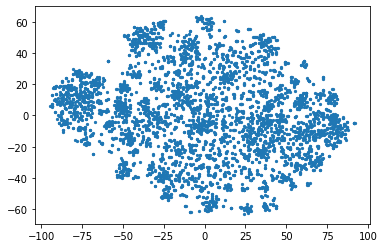

In [255]:
def visualize_embeddings(embeddings, size=10, labels=None):
    tsne = TSNE(n_components=2, learning_rate='auto')
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.show()

visualize_embeddings(embeddings, size=5)

### Dimensionality reduction using PCA

Use PCA to reduce dimensionality while retaining 90% of variance in data.

In [256]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

Dimension reduced embedding shape: (4524, 119)


### Vector Representation of restaurants

Average the vectors of the menu items of each restaurant to create a vector representation of the restaurant.

In [257]:
restaurant_df = df.drop(columns=[ITEM])
restaurant_df = restaurant_df.groupby(RESTAURANT).mean().reset_index()

### Find the best number of clusters

Use silhouette score (higher the better) to find the best k.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

Silhouette scores: {5: 0.056705177, 6: 0.057874013, 7: 0.063566424, 8: 0.0543881, 9: 0.05312703, 10: 0.052431073, 11: 0.05601256, 12: 0.05603037, 13: 0.0535479, 14: 0.016202318, 15: 0.050541908, 16: 0.064878225, 17: 0.03335375, 18: 0.038960908, 19: 0.059847437, 20: 0.07816308, 21: 0.02305087, 22: 0.034523994, 23: 0.07093353, 24: 0.041365027, 25: 0.052111797, 26: 0.036878716, 27: 0.040218186, 28: 0.029546207, 29: 0.05695276}


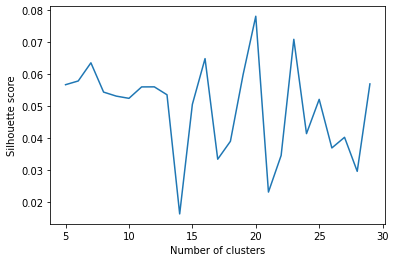

In [267]:
restaurant_embeddings = [embedding for embedding in restaurant_df[EMBEDDING].values]

candidate_k_values = list(range(5, 30))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values: 
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(restaurant_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(restaurant_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### Label restaurants with clusters

In [268]:
best_k = 20
restaurant_df[CLUSTER] = kmeans_labels[best_k - candidate_k_values[0]]

### Visualize restaurant clusters

Not very well defined clusters, other than few of them at the edge.

/opt/homebrew/anaconda3/envs/mic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


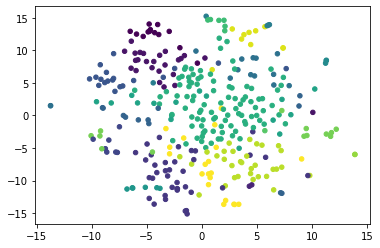

In [269]:
restaurant_embeddings = np.array(restaurant_embeddings)

visualize_embeddings(restaurant_embeddings, size=20, labels=restaurant_df[CLUSTER].values)

In [270]:
restaurant_df.sort_values(by=CLUSTER, inplace=True)
restaurant_df.to_csv('data/restaurants_clustered.csv', index=False, columns=[RESTAURANT, CLUSTER])

### Inspect clusters

Tried to look at what the most common words in the menu items for restaurants in each cluster are.

In [286]:

def most_common_words(x):
    word_salad = ' '.join(x.values).lower().split()
    ctr = Counter(word_salad)

    return ctr.most_common(3)

menuitems_clustered_df = df.merge(restaurant_df, on=RESTAURANT, how='left')
menuitems_clustered_df.groupby(CLUSTER)[ITEM].apply(most_common_words).reset_index()

,Cluster,Original food Item
0,0,"[(chicken, 100), (breast, 22), (rice, 15)]"
1,1,"[(beef, 55), (taco, 46), (chicken, 35)]"
2,2,"[(fruit, 5), (super, 2), (v, 2)]"
3,3,"[(cream, 143), (ice, 118), (chocolate, 99)]"
4,4,"[(bread, 8), (rye, 4), (artisan, 2)]"
5,5,"[(pizza, 215), (crust, 77), (slice, 65)]"
6,6,"[(cheese, 21), (pizza, 9), (tomato, 7)]"
7,7,"[(sauce, 17), (roasted, 8), (garlic, 6)]"
8,8,"[(shrimp, 14), (buttery, 7), (breaded, 6)]"
9,9,"[(salsa, 3), (classic, 1), (gourmet, 1)]"


### Cluster sizes

Few oddly small clusters (2, 9, 14, 16), and one very large cluster (12).

<AxesSubplot:>

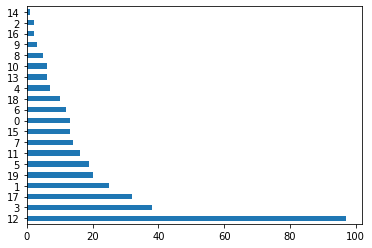

In [299]:
restaurant_df[CLUSTER].value_counts().plot(kind='barh')